# IPBMA_6: Projection Radiography
### Author: Liu Cong and Ulloa Ferrer,Leonardo

In [56]:
import numpy as np
import matplotlib.pyplot as pyplot
import sys, os
from auxFiles.auxFnc import *
from auxFiles.phantomsFnc import *
from auxFiles.plotFnc import *

try:
    auxFnc = os.path.join(sys.path[0], 'auxFiles', 'auxFnc.py')
    phantomsFnc = os.path.join(sys.path[0], 'auxFiles', 'phantomsFnc.py')
    plotFnc = os.path.join(sys.path[0], 'auxFiles', 'plotFnc.py')
    %run {auxFnc}
    %run {phantomsFnc}
    %run {plotFnc}
except:
    auxFnc = os.path.join('.', 'auxFiles', 'auxFnc.py')
    phantomsFnc = os.path.join('.', 'auxFiles', 'phantomsFnc.py')
    plotFnc = os.path.join('.', 'auxFiles', 'plotFnc.py')
    %run {auxFnc}
    %run {phantomsFnc}
    %run {plotFnc}

SOURCE

In [57]:
# source(kVp, N0)
# return number of photoms (N0), efective energy (eE)

kVp= 30
I0= 250  
N0, eE= source(kVp, I0)

print(N0, eE)

250 12.0


BREAST PHANTOM

In [58]:
# OBJECT
# phantom(size, eE)
# return phantomData

size= 256
obj= breast_phantom(size, eE)

0.0 2.27 3.19 4.14


QUANTUM IMAGE. FRONTAL VIEW.

In [59]:
# Interaction
# return qImage -> Quantum Image, ideal conditions

prj= 'frontal'
img= interactor_PR(N0, obj, prj)

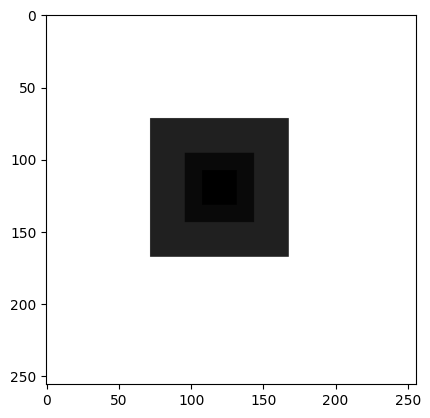

In [60]:
pyplot.imshow(img, cmap="gray")
pyplot.show()

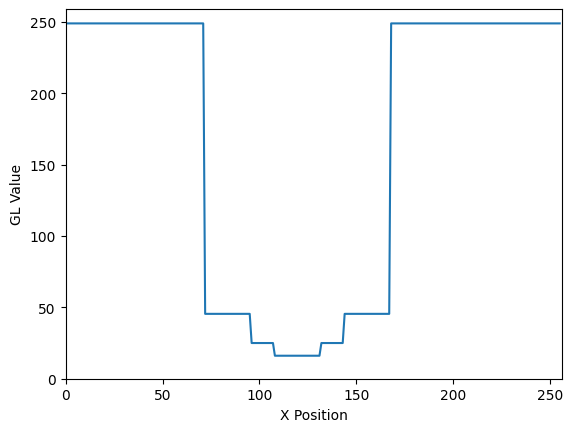

In [61]:
plotLineH(img, 128)

In [62]:
# Get Distribution of cells per Photons

nCP= getNumberCellsPhoton(img, N0)
print(f'Number of Cells (Quantum image): {int(sum(nCP[1])):d}')

Number of Cells (Quantum image): 65536


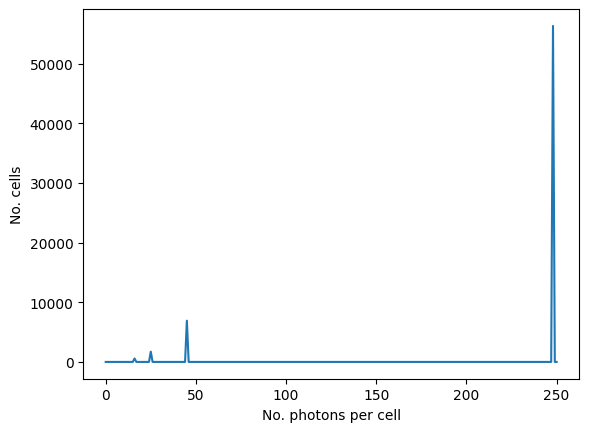

In [63]:
plotDistribution(nCP, 'No. photons per cell', 'No. cells')

QUANTUM IMAGE. LATERAL VIEW.

In [64]:
# Interaction
# return qImage -> Quantum Image, ideal conditions

prj= 'lateral'
img= interactor_PR(N0, obj, prj)

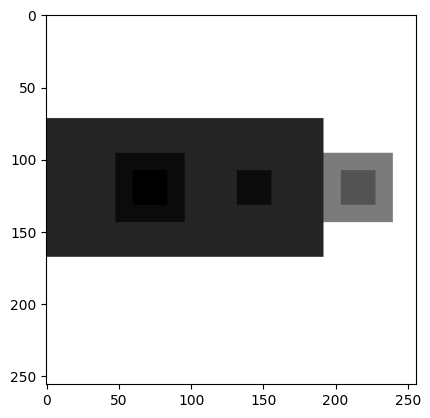

In [65]:
pyplot.imshow(img, cmap="gray")
pyplot.show()

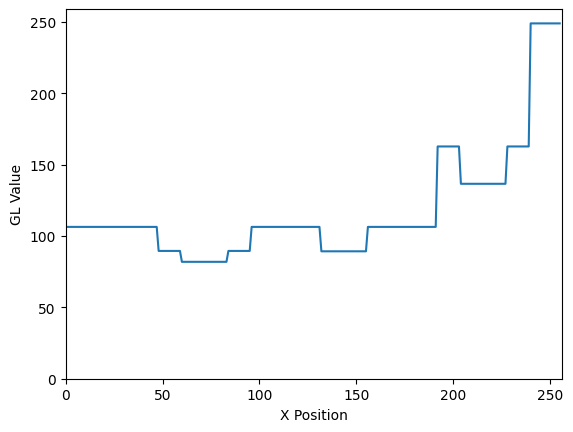

In [66]:
plotLineH(img, 128)

In [67]:
# fName= "coefAtenuacionAir.csv"
fName= "coefAtenuacionCalcium.csv"
mu= getCoef(fName, eE)
sArtifact= 2

In [68]:
pos_1= [72, 120, 120]
obj_microCal= insertArtifact(obj, pos_1, sArtifact, mu)

pos_2= [144, 120, 120]
obj_microCal= insertArtifact(obj_microCal, pos_2, sArtifact, mu)

pos_3= [214, 120, 120]
obj_microCal= insertArtifact(obj_microCal, pos_3, sArtifact, mu)

In [69]:
img= interactor_PR(N0, obj_microCal, prj)

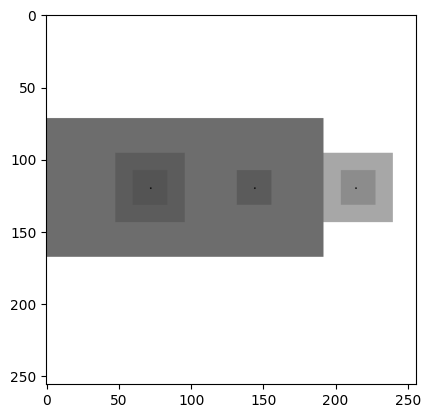

In [70]:
pyplot.imshow(img, cmap="gray")
pyplot.show()

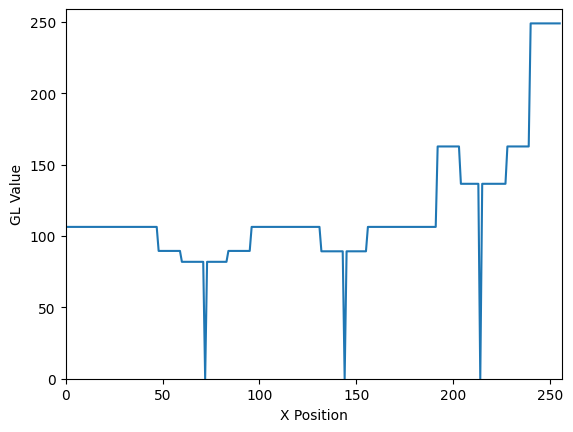

In [71]:
plotLineH(img, 120)

DETECTED IMAGE

In [72]:
# Detection
# dImage -> The detected image, without noise.
from math import floor
    

def down_scale_image(img, n, m):
    n0, m0 = img.shape
    cell_height = n0/n
    cell_width = m0/m
    row_rem = 1
    curr_row = 0
    value =0
    result = np.zeros((n,m))
    for i in range(n):
        height_integer = floor(cell_height - row_rem)
        height_fraq = (cell_height - row_rem) - height_integer
        col_rem = 1
        curr_col = 0
        for j in range(m):

            width_integer = floor(cell_width - col_rem)
            width_fraq = (cell_width - col_rem) - width_integer

            # left up corner
            value += img[curr_row,curr_col]*row_rem*col_rem

            # upper row
            value += np.sum(img[curr_row,curr_col + 1: curr_col + width_integer + 1])*row_rem
            if width_fraq > 0.00000001:
                # right top corner
                value += img[curr_row,curr_col + width_integer + 1]*row_rem*width_fraq

                # right column
                value += np.sum(img[curr_row + 1: curr_row + height_integer + 1,
                                    curr_col + width_integer + 1])*width_fraq
            
            if height_fraq > 0.00000001:
                # bottom row
                value += np.sum(img[curr_row + height_integer + 1,
                            curr_col + 1: curr_col + width_integer + 1])*height_fraq
                
                # bottom left corner
                value += img[curr_row + height_integer + 1,curr_col]*height_fraq*col_rem

            if width_fraq > 0.00000001 and height_fraq > 0.00000001:
                # right bottom corner
                value += img[curr_row + height_integer + 1
                            ,curr_col + width_integer + 1]*height_fraq*width_fraq
            
            # left column
            value += np.sum(img[curr_row + 1: curr_row + height_integer + 1,
                                curr_col])*col_rem
            
            # the middle
            value += np.sum(img[curr_row + 1: curr_row + height_integer + 1,
                                curr_col + 1: curr_col + width_integer + 1])
            result[i,j] = value
            value = 0
            curr_col += width_integer + 1
            col_rem = 1 - width_fraq

        curr_row += height_integer + 1
        row_rem = 1 - height_fraq

    return result
        

            
            


def detector_QDE(qImage : np.ndarray, n, m,qde):
    n0, m0 = qImage.shape
    result = None
    if n < n0 and m < m0:
        result =  down_scale_image(qImage,n,m)

    elif n > n0 and m > m0:
        result = None
    else:
        raise NotImplementedError()
    result = result*qde
    return result
f= 2
QDE= 0.75
dImage= detector_QDE(img, int(size/f), int(size/f), QDE)

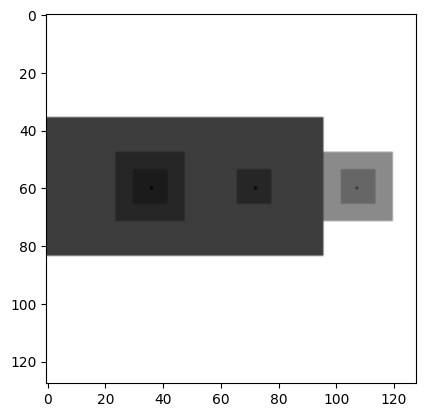

In [73]:
pyplot.imshow(dImage, cmap="gray")
pyplot.show()

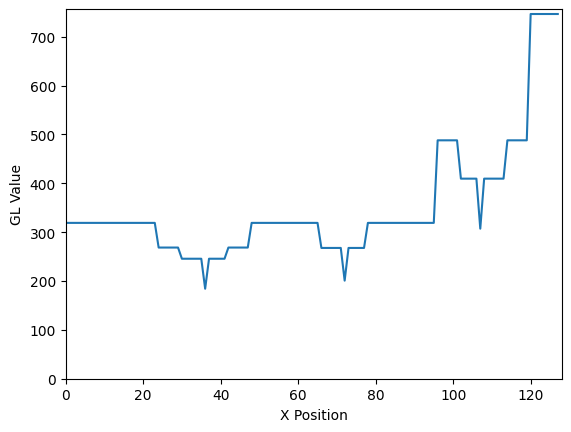

In [74]:
plotLineH(dImage, int(120/f))

In [75]:
nCP= getNumberCellsPhoton(dImage, N0*3)
print(f'Number of Cells (Detected image): {int(sum(nCP[1])):d}')
nPCD= getNumberPhotonsCell(dImage, N0)
print(f'Number of Photons (Detected image): {int(sum(nPCD[1])):d}')
nPCQ= getNumberPhotonsCell(img, N0)
print(f'Number of Photons (Quantum image): {int(sum(nPCQ[1])):d}')
print(f'Percentage Detected: {100*sum(nPCD[1])/sum(nPCQ[1]):.2f}%')

Number of Cells (Detected image): 16384
Number of Photons (Detected image): 10062357
Number of Photons (Quantum image): 13416477
Percentage Detected: 75.00%


In [76]:
# Detection
# dImageNoise -> The detected image, under the hypothesis of Poisson distribution.
from PIL import Image

f= 2
QDE= 0.75
dImageNoise= detectorNoiseFullP_QDE(img, int(size/f), int(size/f), QDE)

In [77]:
nCP= getNumberCellsPhoton(dImageNoise, N0*3)
print(f'Number of Cells (Detected image): {int(sum(nCP[1])):d}')
nPCD= getNumberPhotonsCell(dImageNoise, N0)
print(f'Number of Photons (Detected image): {int(sum(nPCD[1])):d}')
nPCQ= getNumberPhotonsCell(img, N0)
print(f'Number of Photons (Quantum image): {int(sum(nPCQ[1])):d}')
print(f'Percentage Detected: {100*sum(nPCD[1])/sum(nPCQ[1]):.2f}%')

Number of Cells (Detected image): 12368
Number of Photons (Detected image): 10062357
Number of Photons (Quantum image): 13416477
Percentage Detected: 75.00%


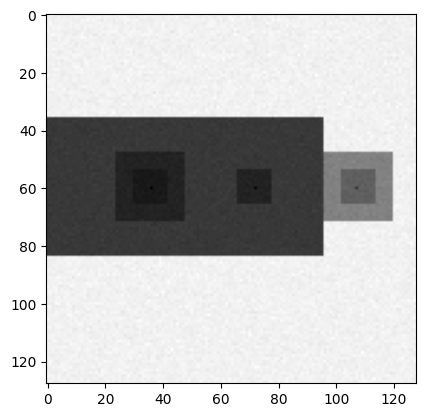

In [78]:
pyplot.imshow(dImageNoise, cmap="gray")
pyplot.show()

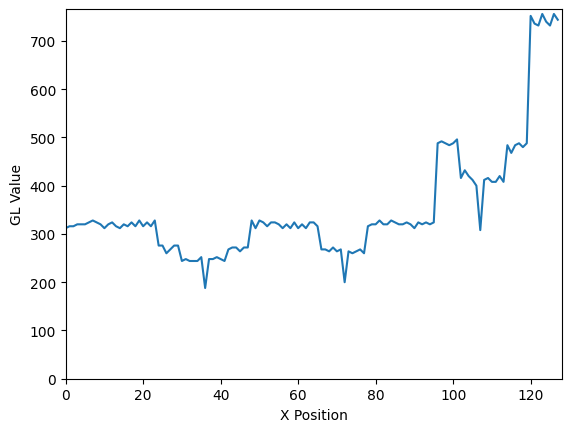

In [79]:
plotLineH(dImageNoise, int(120/f))

### Experiments
Experiment 1. Microcalcification visualization.

In [80]:
# SOURCE

kVp= 30
I0= 250  
N0, eE= source(kVp, I0)
QDE= 0.75

print(N0, eE)

250 12.0


In [81]:
# OBJECT

size= 256
obj= breast_phantom(size, eE)

0.0 2.27 3.19 4.14


In [82]:
# MICROCALCIFICATION INSERTION
fName= "coefAtenuacionCalcium.csv"
mu= getCoef(fName, eE)
sArtifact= 2

pos_1= [72, 120, 120]
obj_microCal= insertArtifact(obj, pos_1, sArtifact, mu)

pos_2= [144, 120, 120]
obj_microCal= insertArtifact(obj_microCal, pos_2, sArtifact, mu)

pos_3= [214, 120, 120]
obj_microCal= insertArtifact(obj_microCal, pos_3, sArtifact, mu)

In [83]:
# INTERACTION

prj= 'lateral'
img= interactor_PR(N0, obj_microCal, prj)

Experiment 1.1. Baseline --> Quantum Image Resolution == Detected Image Resolution

In [84]:
f= 1
dImage= detectorNoiseFullP_QDE(img, int(size/f), int(size/f), QDE)

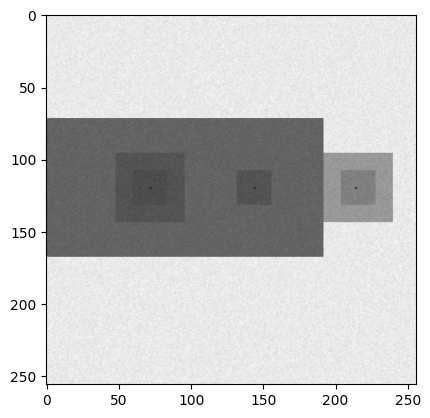

In [85]:
pyplot.imshow(dImage, cmap="gray")
pyplot.show()

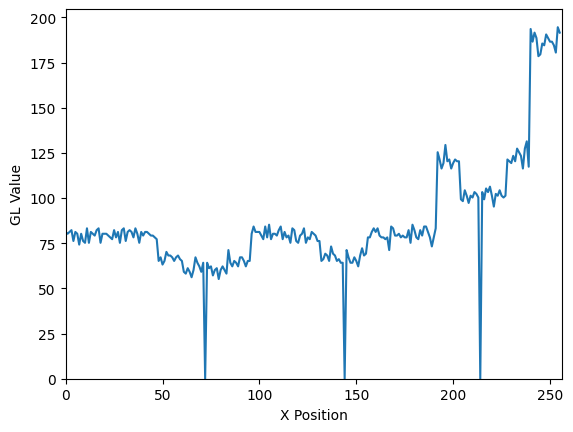

In [86]:
plotLineH(dImage, int(120/f))

Experiment 1.2. Quantum Image Resolution < Detected Image Resolution

In [87]:
f= 0.5
dImage= detectorNoiseFullP_QDE(img, int(size/f), int(size/f), QDE)

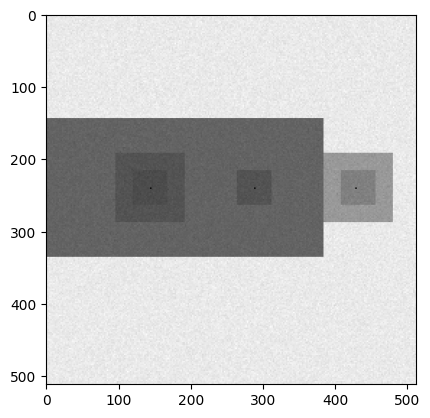

In [88]:
pyplot.imshow(dImage, cmap="gray")
pyplot.show()

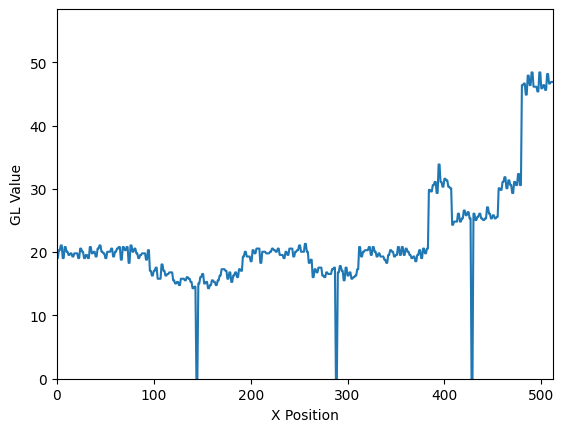

In [89]:
plotLineH(dImage, int(120/f))

Experiment 1.3. Quantum Image Resolution > Detected Image Resolution

In [ ]:
f= 2
dImage= detectorNoiseFullP_QDE(img, int(size/f), int(size/f), QDE)

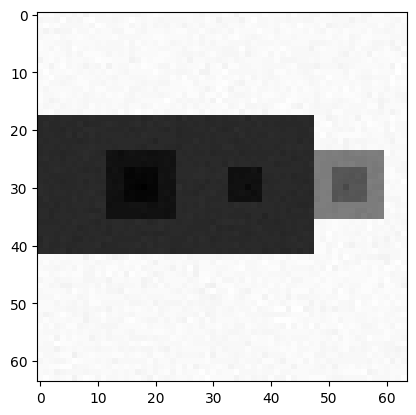

In [91]:
pyplot.imshow(dImage, cmap="gray")
pyplot.show()

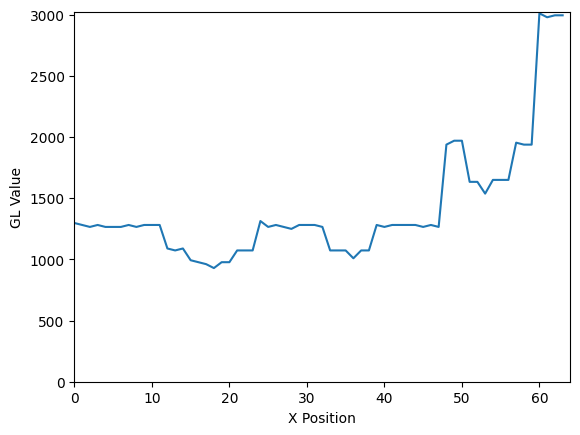

In [92]:
plotLineH(dImage, int(120/f))

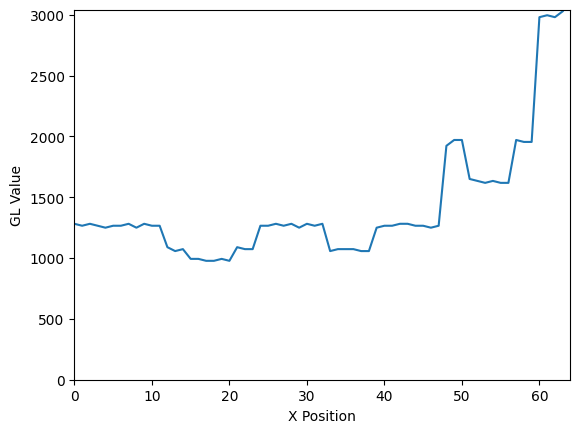

In [93]:
plotLineH(dImage, int(120/f)-1)    # Better option to visualize the microcalcification

Experiment 2. Noise vs Spatial Resolution Analysis.

In [94]:
# SOURCE

kVp= 30
I0= 250  
N0, eE= source(kVp, I0)
QDE= 0.8

print(N0, eE)

250 12.0


In [95]:
# OBJECT

size= 256
obj= cube_phantom_nh(size, eE)

4.14 0.0 3.87


In [96]:
# INTERACTION

prj= 'frontal'
img= interactor_PR(N0, obj, prj)

Experiment 2.1. Baseline --> Quantum Image Resolution == Detected Image Resolution

In [97]:
# DETECTION

f= 1
dImage= detectorNoiseFullP_QDE(img, int(size/f), int(size/f), QDE)

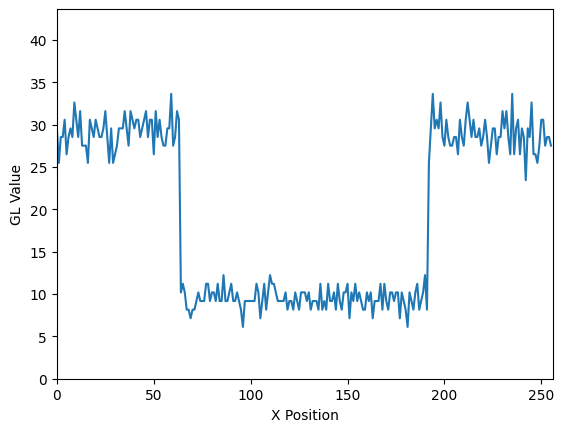

In [98]:
plotLineH(dImage, int(120/f))

In [99]:
nCP= getNumberCellsPhoton(dImage, N0)
print(f'Number of Cells (Detected image): {int(sum(nCP[1])):d}')
nPCD= getNumberPhotonsCell(dImage, N0)
print(f'Number of Photons (Detected image): {int(sum(nPCD[1])):d}')
nPCQ= getNumberPhotonsCell(img, N0)
print(f'Number of Photons (Quantum image): {int(sum(nPCQ[1])):d}')
print(f'Percentage Detected: {100*sum(nPCD[1])/sum(nPCQ[1]):.2f}%')

Number of Cells (Detected image): 65536
Number of Photons (Detected image): 1576886
Number of Photons (Quantum image): 1971107
Percentage Detected: 80.00%


In [100]:
# SNR 1

w= 10
snr_1= getSNR(dImage, 128, 128, w)

print(f'SNR 1: {snr_1: .3f}')

SNR 1:  8.716


Experiment 2.2. Quantum Image Resolution < Detected Image Resolution

In [101]:
# DETECTION

f= 0.5
dImage= detectorNoiseFullP_QDE(img, int(size/f), int(size/f), QDE)

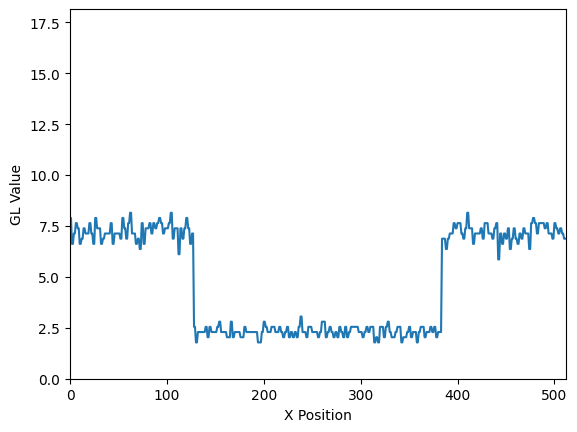

In [102]:
plotLineH(dImage, int(120/f))

In [103]:
nCP= getNumberCellsPhoton(dImage, N0)
print(f'Number of Cells (Detected image): {int(sum(nCP[1])):d}')
nPCD= getNumberPhotonsCell(dImage, N0)
print(f'Number of Photons (Detected image): {int(sum(nPCD[1])):d}')
nPCQ= getNumberPhotonsCell(img, N0)
print(f'Number of Photons (Quantum image): {int(sum(nPCQ[1])):d}')
print(f'Percentage Detected: {100*sum(nPCD[1])/sum(nPCQ[1]):.2f}%')

Number of Cells (Detected image): 262144
Number of Photons (Detected image): 1576886
Number of Photons (Quantum image): 1971107
Percentage Detected: 80.00%


In [104]:
# SNR 2

w= 10
snr_2= getSNR(dImage, 256, 256, w)

print(f'SNR 1: {snr_2: .3f}')

SNR 1:  8.705


Experiment 2.3. Quantum Image Resolution > Detected Image Resolution

In [105]:
# DETECTION

f= 4
dImage= detectorNoiseFullP_QDE(img, int(size/f), int(size/f), QDE)

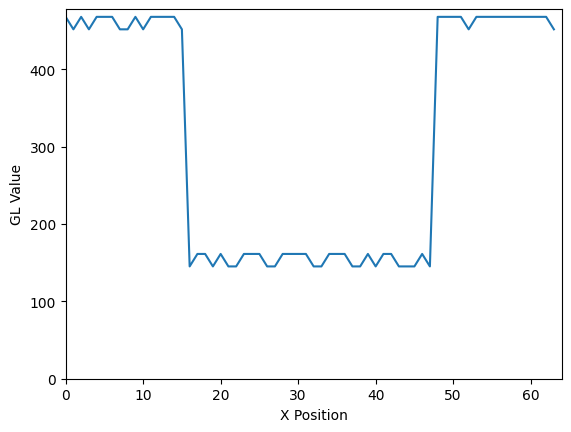

In [106]:
plotLineH(dImage, int(120/f))

In [107]:
nCP= getNumberCellsPhoton(dImage, N0)
print(f'Number of Cells (Detected image): {int(sum(nCP[1])):d}')
nPCD= getNumberPhotonsCell(dImage, N0)
print(f'Number of Photons (Detected image): {int(sum(nPCD[1])):d}')
nPCQ= getNumberPhotonsCell(img, N0)
print(f'Number of Photons (Quantum image): {int(sum(nPCQ[1])):d}')
print(f'Percentage Detected: {100*sum(nPCD[1])/sum(nPCQ[1]):.2f}%')

Number of Cells (Detected image): 1024
Number of Photons (Detected image): 1576886
Number of Photons (Quantum image): 1971107
Percentage Detected: 80.00%


In [108]:
# SNR 3

w= 10
snr_3= getSNR(dImage, 32, 32, w)

print(f'SNR 3: {snr_3: .3f}')

SNR 3:  19.980


In [109]:
print(f'SNR 1: {snr_1: .3f}')
print(f'SNR 2: {snr_2: .3f}')
print(f'SNR 3: {snr_3: .3f}')

SNR 1:  8.716
SNR 2:  8.705
SNR 3:  19.980


In [110]:
assert snr_1 > snr_2 and snr_1 < snr_3, "Something wrong happens"